# Data Visualizations for Gaia DR 2 Solar System Objects

Gaia DR2 released some solar system object data. Including time series! It'd be cool to visualize those to see what's interesting and where I might want to start my data analysis.

So let's do that!

We're going to use [altair](https://altair-viz.github.io/index.html) for the data visualizations.

In [1]:
import altair as alt
alt.renderers.enable('notebook')
from altair import datum

import numpy as np
import pandas as pd

alt.data_transformers.enable('json')
alt.data_transformers.enable('default', max_rows=None)

DataTransformerRegistry.enable('default')

Note that in order to keep the size of the notebook down, we're going to *not* load the data into the notebook, but just refer to an external file. If you need to find those files, you can look at the `GaiaDR2_SSO_DataPrep.ipynb` notebook in the same folder as this one.

Here's where my data is located, which we'll need for finding the correct data files.

In [8]:
datadir = "../data/"

Note that altair requires *relative* paths in order to render. You can't include absolute paths (you can, however, include URLs to data that's online somewhere). I'd recommend sticking all your data into the directory above. 

For the purposes of this notebook, we're going to look only at the `small` data sets we made in the data prep notebooks, in order to keep the size in memory small-ish.

Let's start by plotting the position in the sky for our asteroids. This is strictly speaking the *mean* position (we're going to average over the position columns, since asteroids move pretty quickly in the sky).

The position is defined in `Right Ascension` (`ra`) and `Declination` (`dec`), which are astronomy versions of latitude and longitude, since we essentially observe the sky on a sphere:

In [9]:
datafile = datadir + "gaia_mpc_sdss_small.json"

In [10]:
datafile

'../data/gaia_mpc_sdss_small.json'

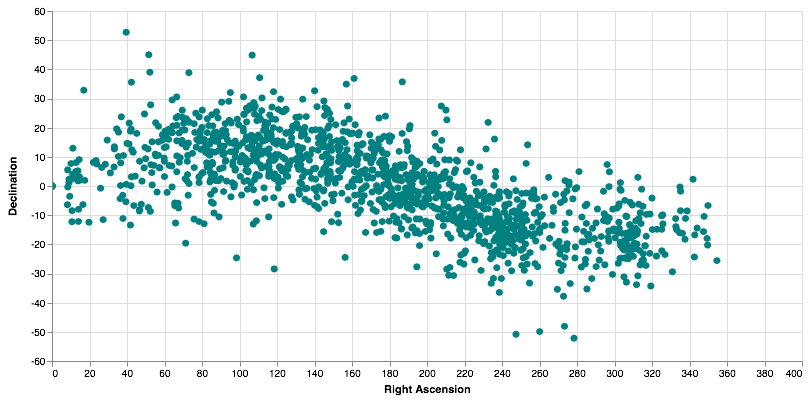

In [13]:
mean_ra = alt.AggregatedFieldDef(field='ra', op='mean', 
                                 **{'as': 'mean_ra'})
mean_dec = alt.AggregatedFieldDef(field='dec', op='mean', 
                                  **{'as': 'mean_dec'})

mean_denom = alt.AggregatedFieldDef(field="denomination", op="max", 
                                    **{"as": "mean_denom"})


pos = alt.Chart(datafile).mark_point(filled=True).encode(
    x=alt.X("mean_ra:Q", axis=alt.Axis(title='Right Ascension'), 
            scale=alt.Scale(zero=False)),
    y=alt.Y("mean_dec:Q", axis=alt.Axis(title="Declination"), 
            scale=alt.Scale(zero=False)),
    color = alt.value("teal"),
    size=alt.value(50),
    tooltip="mean_denom:N",
    opacity=alt.value(1.0)
).transform_aggregate(
    aggregate=[mean_ra, mean_dec, mean_denom],
    groupby=["number_mp"]
).properties(
    height=350,
    width=750
).interactive()

pos

So that's cool! You can zoom and move around in this plot, and you can hover over a data point to see the MPC designation of this asteroid. You could add other information to the tooltip that does the hovering, but we'll not do that now.

Another thing we might be interested in is the distribution of data points for all the asteroids. This is important because right now, we have no idea how often Gaia observed a given asteroid. 

Let's make a bar plot of those:

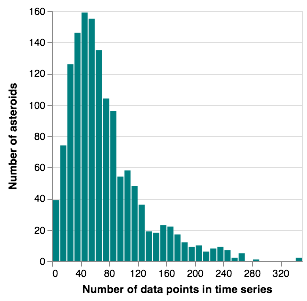

In [15]:
mean_counts = alt.AggregatedFieldDef(field="counts", op="mean", **{"as":"mean_counts"})

cts_plot = alt.Chart(datafile).mark_bar().encode(
    x=alt.X("mean_counts:Q", bin=alt.Bin(maxbins=40), axis=alt.Axis(title="Number of data points in time series")),
    y=alt.Y("count()", axis=alt.Axis(title="Number of asteroids")),
    color = alt.value("teal")
).transform_aggregate(
    aggregate=[mean_counts],
    groupby=["number_mp"]
).properties(
    width=250,
    height=250
)

cts_plot

Okay, cool, so there are ~40-80 data points for each asteroids, with some that are *much* better sampled (up to 350 or so) and a few that are less well sampled.

If we wanted to know whether there was any preferential direction on the sky where asteroids were better sampled (there shouldn't be), we could link those two plots together:

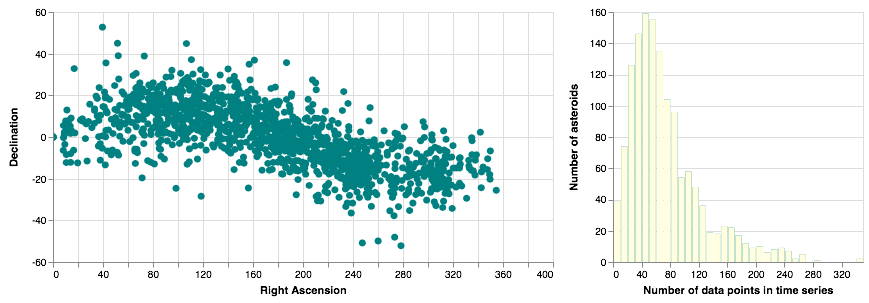

In [26]:
# calculate mean quantities for unfolded data
mean_ra = alt.AggregatedFieldDef(field='ra', op='mean', 
                                 **{'as': 'mean_ra'})
mean_dec = alt.AggregatedFieldDef(field='dec', op='mean', 
                                  **{'as': 'mean_dec'})

mean_denom = alt.AggregatedFieldDef(field="denomination", op="max", 
                                    **{"as": "mean_denom"})

mean_counts = alt.AggregatedFieldDef(field="counts", op="mean", **{"as":"mean_counts"})


# selector for the counts plot
count_sel = alt.selection_interval(empty="all", encodings=["x"])

# position plot
pos = alt.Chart().mark_point(filled=True).encode(
    x=alt.X("mean_ra:Q", axis=alt.Axis(title='Right Ascension'), 
            scale=alt.Scale(zero=False)),
    y=alt.Y("mean_dec:Q", axis=alt.Axis(title="Declination"), 
            scale=alt.Scale(zero=False)),
    color = alt.value("teal"),
    size=alt.value(50),
    tooltip="mean_denom:N",
    opacity=alt.value(1.0)
).transform_filter(
    count_sel.ref()
).properties(
    height=250,
    width=500
).interactive()


cts_plot = alt.Chart().mark_bar().encode(
    x=alt.X("mean_counts:Q", bin=alt.Bin(maxbins=40), axis=alt.Axis(title="Number of data points in time series")),
    y=alt.Y("count()", axis=alt.Axis(title="Number of asteroids")),
    color = alt.value("teal")
).properties(
    width=250,
    height=250
)

cts_layer = alt.Chart().mark_bar().encode(
    x=alt.X("mean_counts:Q", bin=alt.Bin(maxbins=40), axis=alt.Axis(title="Number of data points in time series")),
    y=alt.Y("count()", axis=alt.Axis(title="Number of asteroids")),
    color=alt.value("lightyellow")
).transform_filter(
    count_sel.ref()
).properties(
    selection=count_sel,
    width=250,
    height=250
)

alt.hconcat(pos, alt.layer(cts_plot, cts_layer), data=datafile).transform_aggregate(
    aggregate=[mean_ra, mean_dec, mean_denom, mean_counts],
    groupby=["number_mp"]
)

You can select an interval on the left plot and then see how the positions on the right change as you shift your interval selection around. There doesn't seem to be a preferential location for any number of data points anywhere, which is good, because Gaia is an all-sky survey.

There are some other interesting quantities we want to plot. For example, we'd like to look at inclination (the tilt of the asteroid's orbit compared to the plane of the solar system), the eccentricity (how elliptical the orbit is), the semi-major axis (the distance between sun and the asteroid when it's farthest away), and the various measurements of brightness (or, in astronomy terms, magnitude). These tell us something about the shape and the type of asteroid we're looking at, and where in the solar system it spends most of its time.

A very standard way of visualizing asteroid data is to plot semi-major axis versus inclination, and then colour the points by a particular definition of *colour*, which astronomers usually use to describe a combination of observations in a certain wavelength range.

For an example, see Figure (5) in [Parker et al., 2008](https://arxiv.org/abs/0807.3762).

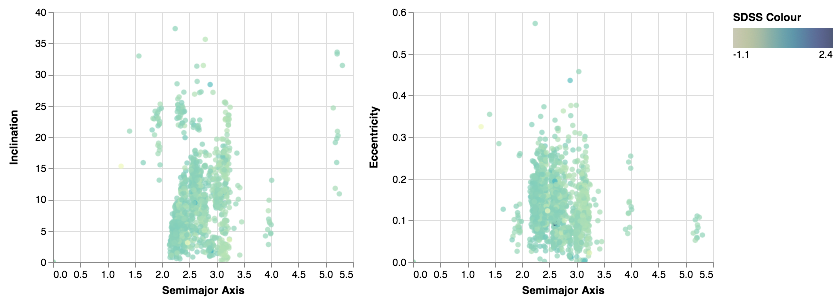

In [36]:
mean_incl = alt.AggregatedFieldDef(field="inclination", 
                                   op="mean", **{"as": "Inclination"})

mean_semimajor = alt.AggregatedFieldDef(field="semimajor_axis", 
                                        op="mean", **{"as": "Semimajor Axis"})

mean_ecc = alt.AggregatedFieldDef(field="ecc", op="mean", **{"as": "Eccentricity"})

mean_colour = alt.AggregatedFieldDef(field="sdss_colour", op="mean", **{"as": "SDSS Colour"})

# scale for the colours
colour_scale = alt.Scale(scheme="yellowgreenblue")

# Define the base chart, with the common parts of the
# background and highlights
base = alt.Chart(datafile).mark_point(filled=True).encode(
#    x=alt.X(alt.repeat('column'), type='quantitative', bin=alt.Bin(maxbins=20)),
#    y='count()',
    x = alt.X("Semimajor Axis:Q", scale=alt.Scale(zero=False), 
              axis=alt.Axis(title="Semimajor Axis")),
    y = alt.Y(alt.repeat("column"), scale=alt.Scale(zero=False), type="quantitative"),
    color=alt.Color("SDSS Colour:Q", scale=colour_scale)
).transform_aggregate(
    aggregate=[mean_colour, mean_incl,
               mean_semimajor, mean_ecc],
    groupby=["number_mp"]
).properties(
    width=300,
    height=250
).repeat(
    column=["Inclination", "Eccentricity"]
).interactive()

base

So this is fun! We could also colour them by the type we very handwavy-ly defined in our data preparation notebook:

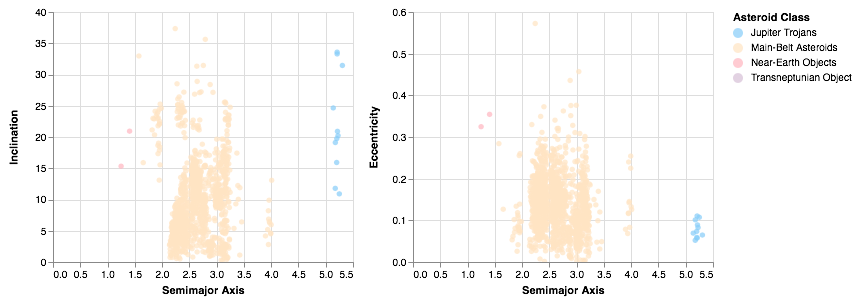

In [37]:
mean_incl = alt.AggregatedFieldDef(field="inclination", 
                                   op="mean", **{"as": "Inclination"})

mean_semimajor = alt.AggregatedFieldDef(field="semimajor_axis", 
                                        op="mean", **{"as": "Semimajor Axis"})

mean_ecc = alt.AggregatedFieldDef(field="ecc", op="mean", **{"as": "Eccentricity"})

mean_type = alt.AggregatedFieldDef(field="type", op="max", **{"as": "Asteroid Class"})

# scale for the colours
colour_scale = alt.Scale(domain=['Jupiter Trojans', 'Main-Belt Asteroids', 
                              "Near-Earth Objects", "Transneptunian Object"],
                      range=["lightskyblue", 'bisque', "lightpink", "thistle"])


# Define the base chart, with the common parts of the
# background and highlights
base = alt.Chart(datafile).mark_point(filled=True).encode(
#    x=alt.X(alt.repeat('column'), type='quantitative', bin=alt.Bin(maxbins=20)),
#    y='count()',
    x = alt.X("Semimajor Axis:Q", scale=alt.Scale(zero=False), 
              axis=alt.Axis(title="Semimajor Axis")),
    y = alt.Y(alt.repeat("column"), scale=alt.Scale(zero=False), type="quantitative"),
    color=alt.Color("Asteroid Class:N", scale=colour_scale)
).transform_aggregate(
    aggregate=[mean_type, mean_incl,
               mean_semimajor, mean_ecc],
    groupby=["number_mp"]
).properties(
    width=300,
    height=250
).repeat(
    column=["Inclination", "Eccentricity"]
).interactive()

base

As you can see, different types of asteroids fall on different locations in terms of semi-major axis, inclination and eccentricity. Jupiter Trojans are farther away than main-belt asteroids, which makes sense, because the asteroid belt is between the sun and Jupiter. Near-Earth objects are close to Earth (duh!), so they have a smaller semi-major axis. 

Now, the last quantity we haven't looked at but would really like to plot are the time series! 

This is going to be difficult, because our time series are *sparse*, and there are many of them! We don't want to plot them all at once, but perhaps we could combine one of the above plots with a selection.

Let's link the plot of sky position above with a a scatter plot of the time series, such that when I click on a particular asteroid, it'll plot the time series:

In [51]:
from altair import datum

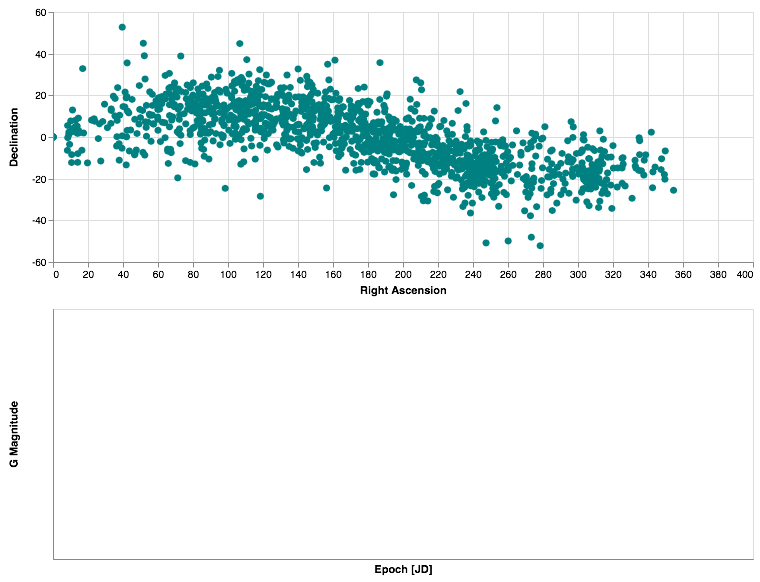

In [66]:
mean_ra = alt.AggregatedFieldDef(field='ra', op='mean', 
                                 **{'as': 'mean_ra'})
mean_dec = alt.AggregatedFieldDef(field='dec', op='mean', 
                                  **{'as': 'mean_dec'})

mean_denom = alt.AggregatedFieldDef(field="denomination", op="max", 
                                    **{"as": "mean_denom"})


# selector for the RA/Dec plot that sends the correct object 
# to the light curve plot
point_sel = alt.selection_single(empty="none", fields=["number_mp"])

# plot of sky position
pos = alt.Chart().mark_point(filled=True).encode(
    x=alt.X("mean_ra:Q", axis=alt.Axis(title='Right Ascension'), 
            scale=alt.Scale(zero=False)),
    y=alt.Y("mean_dec:Q", axis=alt.Axis(title="Declination"), 
            scale=alt.Scale(zero=False)),
    color = alt.condition(point_sel, alt.value("orange"), alt.value("teal")),
    size=alt.value(50),
    tooltip="mean_denom:N",
    opacity=alt.value(1.0)
).transform_aggregate(
    aggregate=[mean_ra, mean_dec, mean_denom],
    groupby=["number_mp"]
).properties(
    selection = point_sel,
    height=250,
    width=700
).interactive()

# time series plot
ts = alt.Chart().mark_point(filled=True).encode(
    x = alt.X("epoch:Q", scale=alt.Scale(zero=False), 
              axis=alt.Axis(title="Epoch [JD]")),
    y = alt.Y("g_mag:Q", scale=alt.Scale(zero=False), axis=alt.Axis(title="G Magnitude")),
    color=alt.value("teal"),
    size=alt.value(50)
).transform_filter(
    point_sel
).properties(
    height=250,
    width=700,
).interactive(bind_y=False)


ts_layer = alt.Chart().mark_line().encode(
    x = alt.X("epoch:Q", scale=alt.Scale(zero=False), 
              axis=alt.Axis(title="Epoch [JD]")),
    y = alt.Y("g_mag:Q", scale=alt.Scale(zero=False), axis=alt.Axis(title="G Magnitude")),
    color=alt.value("teal"),
).transform_filter(
    point_sel
)

alt.vconcat(pos, alt.layer(ts, ts_layer), data=datafile)

We could do the same with our eccentricity and inclination plot:

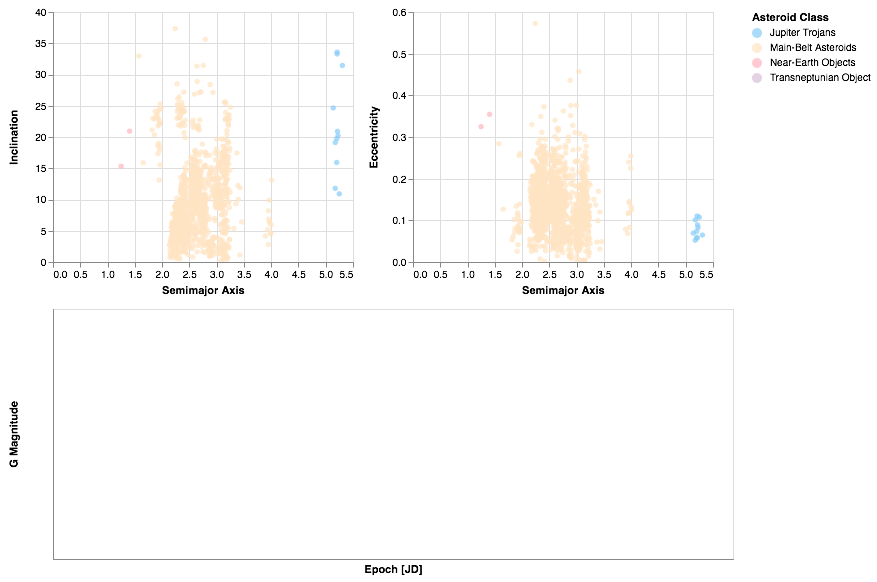

In [69]:
mean_incl = alt.AggregatedFieldDef(field="inclination", 
                                   op="mean", **{"as": "Inclination"})

mean_semimajor = alt.AggregatedFieldDef(field="semimajor_axis", 
                                        op="mean", **{"as": "Semimajor Axis"})

mean_ecc = alt.AggregatedFieldDef(field="ecc", op="mean", **{"as": "Eccentricity"})

mean_type = alt.AggregatedFieldDef(field="type", op="max", **{"as": "Asteroid Class"})

# scale for the colours
colour_scale = alt.Scale(domain=['Jupiter Trojans', 'Main-Belt Asteroids', 
                              "Near-Earth Objects", "Transneptunian Object"],
                      range=["lightskyblue", 'bisque', "lightpink", "thistle"])

# selector for the RA/Dec plot that sends the correct object 
# to the light curve plot
point_sel = alt.selection_single(empty="none", fields=["number_mp"])


# Define the base chart, with the common parts of the
# background and highlights
base = alt.Chart().mark_point(filled=True).encode(
#    x=alt.X(alt.repeat('column'), type='quantitative', bin=alt.Bin(maxbins=20)),
#    y='count()',
    x = alt.X("Semimajor Axis:Q", scale=alt.Scale(zero=False), 
              axis=alt.Axis(title="Semimajor Axis")),
    y = alt.Y(alt.repeat("column"), scale=alt.Scale(zero=False), type="quantitative"),
    color=alt.condition(point_sel, alt.value("teal"), alt.Color("Asteroid Class:N", scale=colour_scale))
).transform_aggregate(
    aggregate=[mean_type, mean_incl,
               mean_semimajor, mean_ecc],
    groupby=["number_mp"]
).properties(
    selection=point_sel,
    width=300,
    height=250
).repeat(
    column=["Inclination", "Eccentricity"]
).interactive()

# time series plot
ts = alt.Chart().mark_point(filled=True).encode(
    x = alt.X("epoch:Q", scale=alt.Scale(zero=False), 
              axis=alt.Axis(title="Epoch [JD]")),
    y = alt.Y("g_mag:Q", scale=alt.Scale(zero=False), axis=alt.Axis(title="G Magnitude")),
    color=alt.value("teal"),
    size=alt.value(50)
).transform_filter(
    point_sel
).properties(
    height=250,
    width=680,
).interactive(bind_y=False)


ts_layer = alt.Chart().mark_line().encode(
    x = alt.X("epoch:Q", scale=alt.Scale(zero=False), 
              axis=alt.Axis(title="Epoch [JD]")),
    y = alt.Y("g_mag:Q", scale=alt.Scale(zero=False), axis=alt.Axis(title="G Magnitude")),
    color=alt.value("teal"),
).transform_filter(
    point_sel
)

alt.vconcat(base, alt.layer(ts, ts_layer), data=datafile)

Now I can click around and try to find perhaps the most appropriate Jupiter Trojan I'd like to analyze, or zoom around the main-belt asteroid and look for interesting sources there.

## Putting It All Together

Now we'd really like to put all of this together in one big plot! Can we do that? Of course! It's going to look a bit messy, but it only really combines everything we've already done above:

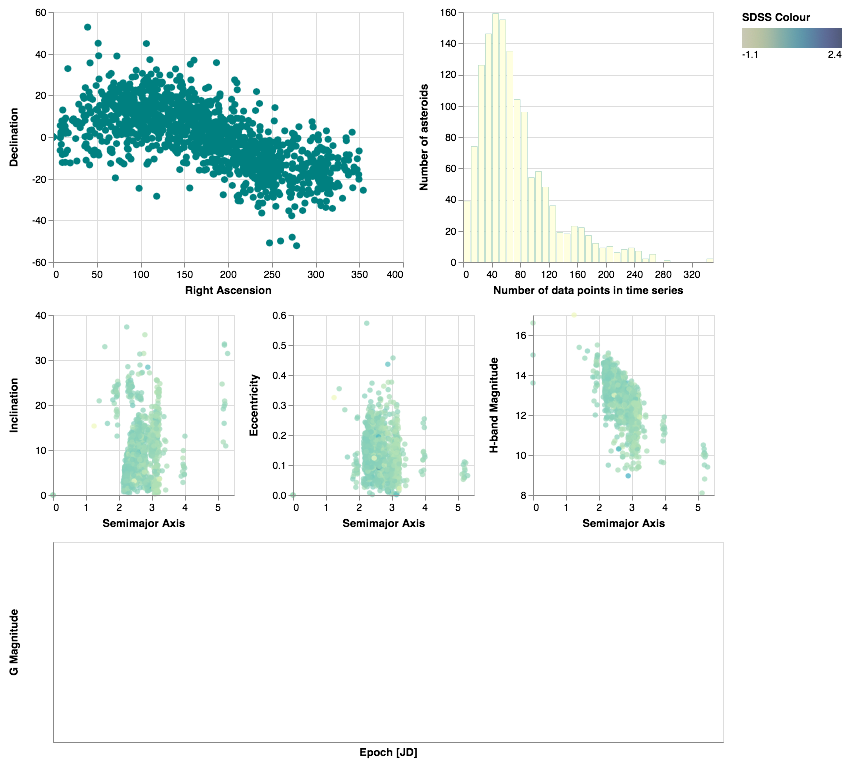

In [80]:
## aggregating fields across the object ID
mean_ra = alt.AggregatedFieldDef(field='ra', op='mean', 
                                 **{'as': 'mean_ra'})
mean_dec = alt.AggregatedFieldDef(field='dec', op='mean', 
                                  **{'as': 'mean_dec'})
mean_denom = alt.AggregatedFieldDef(field="denomination", op="max", 
                                    **{"as": "mean_denom"})
mean_type = alt.AggregatedFieldDef(field="type", op="max", 
                                   **{"as": "mean_type"})

mean_counts = alt.AggregatedFieldDef(field="counts", op="mean", **{"as":"mean_counts"})


mean_colour = alt.AggregatedFieldDef(field="sdss_colour", op="mean", **{"as": "SDSS Colour"})

mean_hmag = alt.AggregatedFieldDef(field="h-mag", op="mean", **{"as": "H-band Magnitude"})

mean_incl = alt.AggregatedFieldDef(field="inclination", 
                                   op="mean", **{"as": "Inclination"})

mean_semimajor = alt.AggregatedFieldDef(field="semimajor_axis", 
                                        op="mean", **{"as": "Semimajor Axis"})

mean_ecc = alt.AggregatedFieldDef(field="ecc", op="mean", **{"as": "Eccentricity"})

colour_scale = alt.Scale(scheme="yellowgreenblue")


# selector for the histogram containing the number of data points per
# light curve
count_sel = alt.selection_interval(empty="all", encodings=["x"])

# selector for the RA/Dec plot that sends the correct object 
# to the light curve plot
point_sel = alt.selection_single(empty="none", fields=["number_mp"])

# eccentricity selection
ecc_sel = alt.selection_interval(empty="all")

# colour scale for the types of objects
ecc_scale = alt.Scale(domain=['Jupiter Trojans', 'Main-Belt Asteroids', 
                              "Near-Earth Objects", "Transneptunian Object"],
                      range=["lightskyblue", 'bisque', "lightpink", "thistle"])

brush = alt.selection(type='interval', empty="all")

# position in the sky
pos = alt.Chart().mark_point(filled=True).encode(
    x=alt.X("mean_ra:Q", axis=alt.Axis(title='Right Ascension'), scale=alt.Scale(zero=False)),
    y=alt.Y("mean_dec:Q", axis=alt.Axis(title="Declination"), scale=alt.Scale(zero=False)),
    color = alt.condition(point_sel, alt.value("lightyellow"), alt.value("teal")),
    size=alt.value(50),
    tooltip="mean_denom:N",
    opacity=alt.value(1.0)
).transform_filter(
    count_sel.ref()
).transform_filter(
    brush.ref()
).properties(
    selection=point_sel,
    height=250,
    width=350
).interactive()


ts = alt.Chart().mark_point(filled=True).encode(
    x = alt.X("epoch:Q", scale=alt.Scale(zero=False), 
              axis=alt.Axis(title="Epoch [JD]")),
    y = alt.Y("g_mag:Q", scale=alt.Scale(zero=False), axis=alt.Axis(title="G Magnitude")),
    color=alt.value("teal"),
    size=alt.value(30)
).transform_filter(
    point_sel
).properties(
    height=200,
    width=670,
).interactive(bind_y=False)


cts_plot = alt.Chart().mark_bar().encode(
    x=alt.X("mean_counts:Q", bin=alt.Bin(maxbins=40), axis=alt.Axis(title="Number of data points in time series")),
    y=alt.Y("count()", axis=alt.Axis(title="Number of asteroids")),
    color = alt.value("teal")
).properties(
    width=250,
    height=250
)

cts_layer = alt.Chart().mark_bar().encode(
    x=alt.X("mean_counts:Q", bin=alt.Bin(maxbins=40), axis=alt.Axis(title="Number of data points in time series")),
    y=alt.Y("count()", axis=alt.Axis(title="Number of asteroids")),
    color=alt.value("lightyellow")
).transform_filter(
    count_sel.ref()
).properties(
    selection=count_sel,
    width=250,
    height=250
)


# Define the base chart, with the common parts of the
# background and highlights
base = alt.Chart().mark_point(filled=True).encode(
    x = alt.X("Semimajor Axis:Q", scale=alt.Scale(zero=False), 
              axis=alt.Axis(title="Semimajor Axis")),
    y = alt.Y(alt.repeat("column"), scale=alt.Scale(zero=False), type="quantitative"),
    color=alt.condition(brush, alt.Color("SDSS Colour:Q", scale=colour_scale), 
                        alt.value("teal"))#alt.value('teal')
).transform_aggregate(
    aggregate=[mean_colour, mean_incl, mean_hmag,
               mean_semimajor, mean_ecc, mean_type],
    groupby=["number_mp"]
).properties(
    selection=brush,
    width=181,
    height=180
).repeat(
    column=["Inclination", "Eccentricity", "H-band Magnitude"]
)


alt.vconcat(alt.hconcat(pos, alt.layer(cts_plot, cts_layer), data=datafile).transform_aggregate(
            aggregate=[mean_ra, mean_dec, mean_denom, mean_counts, mean_hmag,
                        mean_ecc, mean_semimajor, mean_type, mean_incl, mean_colour],
            groupby=["number_mp"]), base, ts, data=datafile)

### Designing for the Web

I have a dark website set up [here](), where I'd like to stick this data visualization. 
This website is dark, so I need to set up my plot such that the lines and text all show up correctly:

In [109]:
bkg_colour = "#18183D"

grid_colour = "darkgrey"
label_colour = "lightgrey"

highlight_colour= "#FFFFD9"
mean_colour = "#7FCDBB"
fade_colour = "#225EA8"

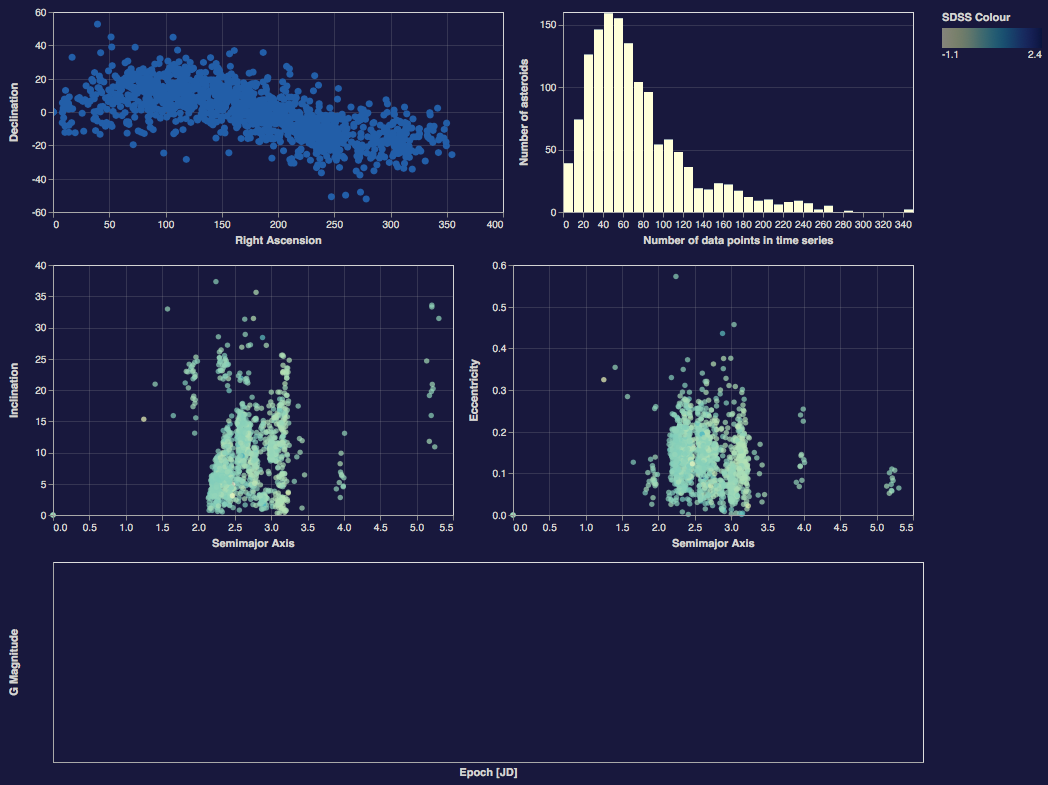

In [110]:
## aggregating fields across the object ID
mean_ra = alt.AggregatedFieldDef(field='ra', op='mean', 
                                 **{'as': 'mean_ra'})
mean_dec = alt.AggregatedFieldDef(field='dec', op='mean', 
                                  **{'as': 'mean_dec'})
mean_denom = alt.AggregatedFieldDef(field="denomination", op="max", 
                                    **{"as": "mean_denom"})
mean_type = alt.AggregatedFieldDef(field="type", op="max", 
                                   **{"as": "mean_type"})

mean_counts = alt.AggregatedFieldDef(field="counts", op="mean", **{"as":"mean_counts"})


mean_colour = alt.AggregatedFieldDef(field="sdss_colour", op="mean", **{"as": "SDSS Colour"})

mean_hmag = alt.AggregatedFieldDef(field="h-mag", op="mean", **{"as": "H-band Magnitude"})

mean_incl = alt.AggregatedFieldDef(field="inclination", 
                                   op="mean", **{"as": "Inclination"})

mean_semimajor = alt.AggregatedFieldDef(field="semimajor_axis", 
                                        op="mean", **{"as": "Semimajor Axis"})

mean_ecc = alt.AggregatedFieldDef(field="ecc", op="mean", **{"as": "Eccentricity"})

colour_scale = alt.Scale(scheme="yellowgreenblue")


# selector for the histogram containing the number of data points per
# light curve
count_sel = alt.selection_interval(empty="all", encodings=["x"])

# selector for the RA/Dec plot that sends the correct object 
# to the light curve plot
point_sel = alt.selection_single(empty="none", fields=["number_mp"])

# eccentricity selection
ecc_sel = alt.selection_interval(empty="all")

# colour scale for the types of objects
ecc_scale = alt.Scale(domain=['Jupiter Trojans', 'Main-Belt Asteroids', 
                              "Near-Earth Objects", "Transneptunian Object"],
                      range=["lightskyblue", 'bisque', "lightpink", "thistle"])

brush = alt.selection(type='interval', empty="all")

# position in the sky
pos = alt.Chart().mark_point(filled=True).encode(
    x=alt.X("mean_ra:Q", axis=alt.Axis(title='Right Ascension'), scale=alt.Scale(zero=False)),
    y=alt.Y("mean_dec:Q", axis=alt.Axis(title="Declination"), scale=alt.Scale(zero=False)),
    color = alt.condition(point_sel, alt.value(highlight_colour), alt.value(fade_colour)),
    size=alt.value(50),
    tooltip="mean_denom:N",
    opacity=alt.value(1.0)
).transform_filter(
    count_sel.ref()
).transform_filter(
    brush.ref()
).properties(
    selection=point_sel,
    height=200,
    width=450
).interactive()


ts = alt.Chart().mark_point(filled=True).encode(
    x = alt.X("epoch:Q", scale=alt.Scale(zero=False), 
              axis=alt.Axis(title="Epoch [JD]")),
    y = alt.Y("g_mag:Q", scale=alt.Scale(zero=False), axis=alt.Axis(title="G Magnitude")),
    color=alt.value(highlight_colour),
    size=alt.value(30)
).transform_filter(
    point_sel
).properties(
    height=200,
    width=870,
).interactive(bind_y=False)

ts_layer = alt.Chart().mark_line(opacity=0.3).encode(
    x = alt.X("epoch:Q", scale=alt.Scale(zero=False), 
              axis=alt.Axis(title="Epoch [JD]")),
    y = alt.Y("g_mag:Q", scale=alt.Scale(zero=False), axis=alt.Axis(title="G Magnitude")),
    color=alt.value(highlight_colour),
).transform_filter(
    point_sel
)

cts_plot = alt.Chart().mark_bar().encode(
    x=alt.X("mean_counts:Q", bin=alt.Bin(maxbins=40), axis=alt.Axis(title="Number of data points in time series")),
    y=alt.Y("count()", axis=alt.Axis(title="Number of asteroids")),
    color = alt.value(fade_colour)
).properties(
    width=350,
    height=200
)

cts_layer = alt.Chart().mark_bar().encode(
    x=alt.X("mean_counts:Q", bin=alt.Bin(maxbins=40), axis=alt.Axis(title="Number of data points in time series")),
    y=alt.Y("count()", axis=alt.Axis(title="Number of asteroids")),
    color=alt.value(highlight_colour)
).transform_filter(
    count_sel.ref()
).properties(
    selection=count_sel,
    width=350,
    height=200
)


# Define the base chart, with the common parts of the
# background and highlights
base = alt.Chart().mark_point(filled=True).encode(
    x = alt.X("Semimajor Axis:Q", scale=alt.Scale(zero=False), 
              axis=alt.Axis(title="Semimajor Axis")),
    y = alt.Y(alt.repeat("column"), scale=alt.Scale(zero=False), type="quantitative"),
    color=alt.condition(brush, alt.Color("SDSS Colour:Q", scale=colour_scale), 
                        alt.value(fade_colour))#alt.value('teal')
).transform_aggregate(
    aggregate=[mean_colour, mean_incl, mean_hmag,
               mean_semimajor, mean_ecc, mean_type],
    groupby=["number_mp"]
).properties(
    selection=brush,
    width=400,
    height=250
).repeat(
    column=["Inclination", "Eccentricity"]
)


alt.vconcat(alt.hconcat(pos, alt.layer(cts_plot, cts_layer), data=datafile).transform_aggregate(
            aggregate=[mean_ra, mean_dec, mean_denom, mean_counts, mean_hmag,
                        mean_ecc, mean_semimajor, mean_type, mean_incl, mean_colour],
            groupby=["number_mp"]), base, alt.layer(ts, ts_layer), data=datafile

).configure(
    background=bkg_colour
).configure_axis(
    gridColor=grid_colour,
    gridOpacity=0.2,
    labelColor=label_colour,
    titleColor=label_colour,
    domainColor = grid_colour
).configure_legend(
    labelColor = label_colour,
    titleColor = label_colour
)

... and that's all for our data visualizations for now!